<h1>Fitting nova for flux template</h1>

In [421]:
# SPI model fitting with Stan
# Example: fitting two BG models + one nova model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import stan_utility
import pystan
import pickle
import sys
import time
from IPython.display import Image

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from angular_distance import angular_distance


from utils import make_bg_cuts
from utils import find_nearest

plt.style.use('thomas')

<h3>Reading in the data set</h3>

<h3>Pointing definition in pointin.fits file:</h3>

In [422]:
with fits.open('pointing_filter.fits.gz') as content:
    poin = content[1].data

Np = len(poin)
p = np.arange(Np)
print('Number of pointings in complete data set: ',Np)
Nrsp = 19 # 19 detectors
days = poin['TSTART']
revol_arr = np.array([float(poin['PTID_SPI'][i])/1e4 for i in range(Np)])

Number of pointings in complete data set:  99880


<h3>Data set (counts) in evts_det_spec.fits file:</h3>

In [423]:
with fits.open('evts_det_spec_filter.fits.gz') as content:
    evts = content[1].data
    
data = evts['COUNTS'][:,2].reshape(Np,Nrsp)

<h3>Energy boundaries definition (not important in our case, just illustration purpose):</h3>

In [424]:
with fits.open('energy_boundaries.fits.gz') as content:
    ebds = content[1].data

<h3>Detector dead time in dead_time.fits file:</h3>

In [425]:
with fits.open('dead_time_filter.fits.gz') as content:
    dead = content[1].data

<h3>Background model (already scaled to data) in back_model.fits file:</h3>

In [426]:
with fits.open('back_model.fits.gz') as content:
    bgc = content[2].data
    bgl = content[3].data

bgc_model = bgc['COUNTS'][:,2].reshape(Np,Nrsp)
bgl_model = bgl['COUNTS'][:,2].reshape(Np,Nrsp)

<h3>Complete INTEGRAL nova catalogue until 2018 (see earlier notebooks):</h3>

In [427]:
data_frame = pd.read_csv('INTEGRAL_novae_wTimes.csv')
good_novae = np.where(~np.isnan(data_frame['IJD']) &
                      (data_frame['Dist. \n(kpc)']+data_frame['Dist. Err. (kpc)'] < 25) &
                      ((data_frame['Var. type'] == 'N') |
                       (data_frame['Var. type'] == 'NAa') | 
                       (data_frame['Var. type'] == 'NB') |
                       (data_frame['Var. type'] == 'NC') |
                       (data_frame['Var. type'] == 'NTS')))[0]

<h3>These are our objects:</h3>

In [428]:
names = data_frame['Name'][good_novae].values
names

array(['V556 Nor', 'V3666 Oph', 'V613 Sct', 'V408 Lup', 'V5857 Sgr',
       'V435 CMa', 'V906 Car', 'V3665 Oph', 'V1663 Sco', 'V3664 Oph',
       'V1662 Sco', 'FM Cir', 'V1661 Sco', 'V357 Mus', 'V3663 Oph',
       'V1660 Sco', 'V549 Vel', 'V612 Sct', 'V1405 Cen', 'V3662 Oph',
       'V1657 Sco', 'V5856 Sgr', 'V5855 Sgr', 'V407 Lup', 'V1659 Sco',
       'V611 Sct', 'V1656 Sco', 'V5853 Sgr', 'V5854 Sgr ', 'V1655 Sco',
       'V555 Nor', 'V5850 Sgr', 'V2949 Oph', 'V1831 Aql', 'V5669 Sgr',
       'V2944 Oph', 'V1404 Cen', 'V1658 Sco', 'V1535 Sco', 'V5668 Sgr',
       'V2659 Cyg', 'V5666 Sgr', 'V1830 Aql', 'V556 Ser', 'V339 Del',
       'V1533 Sco', 'V809 Cep', 'V1724 Aql', 'V5593 Sgr', 'V5592 Sgr',
       'V959 Mon', 'V1324 Sco', 'V5589 Sgr', 'V5591 Sgr', 'V2676 Oph',
       'V965 Per', 'V1313 Sco', 'V5588 Sgr', 'V5587 Sgr', 'V1723 Aql ',
       'V5586 Sgr', 'V1310 Sco', 'V5585 Sgr', 'V2674 Oph', 'V2672 Oph',
       'V496 Sct', 'V5581 Sgr', 'V5582 Sgr', 'V5580 Sgr', 'V1212 Cen',
       'V1

<h3>And the corrresponding files:</h3>

In [429]:
!ls -l convskys/
# if that doesnt work, just look at the directory convskys

total 446856
-rw-r--r--  1 thomassiegert  staff   1694639 Jun 28 23:10 convsky_model_SPI_22Na_nova000_pointsource_V556_Nor.fits.gz
-rw-r--r--  1 thomassiegert  staff   2692869 Jun 28 23:10 convsky_model_SPI_22Na_nova001_pointsource_V3666_Oph.fits.gz
-rw-r--r--  1 thomassiegert  staff   2618913 Jun 28 23:10 convsky_model_SPI_22Na_nova002_pointsource_V613_Sct.fits.gz
-rw-r--r--  1 thomassiegert  staff   1699945 Jun 28 23:10 convsky_model_SPI_22Na_nova003_pointsource_V408_Lup.fits.gz
-rw-r--r--  1 thomassiegert  staff   2603190 Jun 28 23:09 convsky_model_SPI_22Na_nova004_pointsource_V5857_Sgr.fits.gz
-rw-r--r--  1 thomassiegert  staff    375330 Jun 28 23:10 convsky_model_SPI_22Na_nova005_pointsource_V435_CMa.fits.gz
-rw-r--r--  1 thomassiegert  staff    789360 Jun 28 23:10 convsky_model_SPI_22Na_nova006_pointsource_V906_Car.fits.gz
-rw-r--r--  1 thomassiegert  staff   2778410 Jun 28 23:10 convsky_model_SPI_22Na_nova007_pointsource_V3665_Oph.fits.gz
-rw-r--r--  1 thomassiegert  staff   276

In [430]:
import os, glob

In [431]:
conv_sky_files = []

dor = 'convskys/'

for dirpath, subdirs, files in os.walk(dor):
    for file in files:
        conv_sky_files.append(dor+file)
            
conv_sky_files = np.array(conv_sky_files)
conv_sky_files = np.sort(conv_sky_files)

In [432]:
t_ndx = np.arange(len(names))[4::5]

In [433]:
conv_sky_files[t_ndx]

array(['convskys/convsky_model_SPI_22Na_nova004_pointsource_V5857_Sgr.fits.gz',
       'convskys/convsky_model_SPI_22Na_nova009_pointsource_V3664_Oph.fits.gz',
       'convskys/convsky_model_SPI_22Na_nova014_pointsource_V3663_Oph.fits.gz',
       'convskys/convsky_model_SPI_22Na_nova019_pointsource_V3662_Oph.fits.gz',
       'convskys/convsky_model_SPI_22Na_nova024_pointsource_V1659_Sco.fits.gz',
       'convskys/convsky_model_SPI_22Na_nova029_pointsource_V1655_Sco.fits.gz',
       'convskys/convsky_model_SPI_22Na_nova034_pointsource_V5669_Sgr.fits.gz',
       'convskys/convsky_model_SPI_22Na_nova039_pointsource_V5668_Sgr.fits.gz',
       'convskys/convsky_model_SPI_22Na_nova044_pointsource_V339_Del.fits.gz',
       'convskys/convsky_model_SPI_22Na_nova049_pointsource_V5592_Sgr.fits.gz',
       'convskys/convsky_model_SPI_22Na_nova054_pointsource_V2676_Oph.fits.gz',
       'convskys/convsky_model_SPI_22Na_nova059_pointsource_V1723_Aql_.fits.gz',
       'convskys/convsky_model_SPI_22Na_

<h3>You see that they are in the same order and have a certain index associated with them, so e.g., convsky_model_SPI_22Na_nova004_pointsource_V5857_Sgr.fits.gz has the index 4 (the first 4 [0..3] are always zero because they happen after the last pointing of our data set):</h3>

In [434]:
filename = 'convsky_model_SPI_22Na_nova004_pointsource_V5857_Sgr.fits.gz'
ndx = 4
print('Source name: ',names[ndx])

Source name:  V5857 Sgr


<h3>Always check that this works out as expected.</h3>

<h3>Smaller indices are later times (thus, smaller data sets):</h3>

In [435]:
# explosion date
T0 = data_frame['IJD'][good_novae].values[ndx]
print('Explosion date [IJD]: ',T0)

# decay constant
tau = 2.602/np.log(2)*365.25
#print(tau)

Explosion date [IJD]:  6672.7229976851895


<h3>We read in the already-convolved sky model response of chosen nova:</h3>

In [436]:
with fits.open('convskys/'+filename) as content:
    nova = content[2].data
    
nova_model = nova['COUNTS'].reshape(Np,Nrsp)

<h3>Expectation for significance (check later if this ~worked out)</h3>

In [437]:
# summing over all detectors (axis=1)
flux_scl = 2e2
nova_counts_time = np.nansum(nova_model/flux_scl,axis=1) # /2e2 to make 2e-3 to 1e-5
# applying exponential decay function
nova_counts_decay = nova_counts_time*np.heaviside(days-T0,1)*np.exp(-(days-T0)/tau)

<h3>Cross check expected counts</h3>

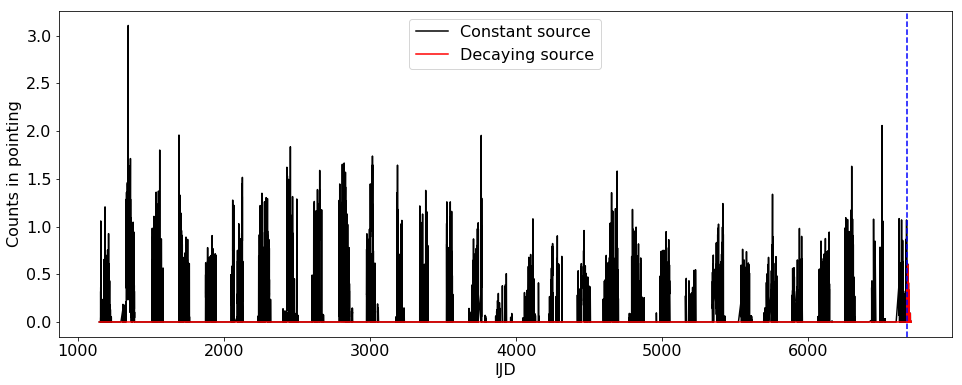

In [438]:
plt.figure(figsize=(16,6))
plt.plot(days,nova_counts_time,label='Constant source')
plt.plot(days,nova_counts_decay,label='Decaying source')
plt.axvline(T0,linestyle='--',color='blue')
plt.xlabel('IJD')
plt.ylabel('Counts in pointing')
plt.legend()
#plt.xlim(T0,)

In [439]:
# same for the data to get total counts in each pointing
data_counts_time = np.sum(data,axis=1)
# remember SNR from last notebook
# decaying source
snr_nova_decay = np.sqrt(np.nancumsum((nova_counts_decay / np.sqrt(data_counts_time))**2))
# constant source
snr_nova_const = np.sqrt(np.nancumsum((nova_counts_time / np.sqrt(data_counts_time))**2))

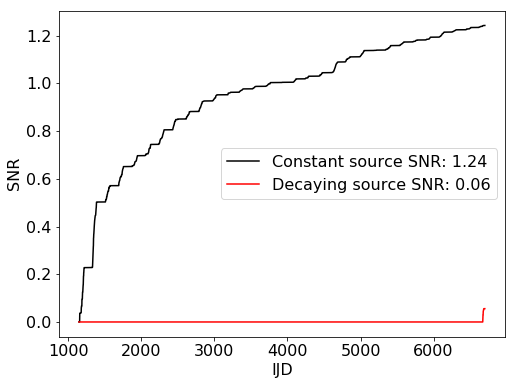

In [440]:
plt.plot(days,snr_nova_const,label='Constant source SNR: '+str('%.2f' % snr_nova_const[-1]))
plt.plot(days,snr_nova_decay,label='Decaying source SNR: '+str('%.2f' % snr_nova_decay[-1]))
plt.xlabel('IJD')
plt.ylabel('SNR')
plt.legend()
plt.savefig('SNR_expectation'+names[ndx]+'.pdf')

In [441]:
4

4

<h3>Load Stan model</h3>

In [442]:
try:
    #read filename.pkl (if already compiled)
    model = pickle.load(open('spimodfit_bg_conti_sep_nozeros.pkl', 'rb'))

except:
    print('Stan model not yet compiled, doing that now')
    ## compile model (if not yet compiled):
    model = pystan.StanModel('spimodfit_bg_conti_sep_nozeros.stan')

    ## save it to the file 'filename.pkl' for later use
    with open('spimodfit_bg_conti_sep_nozeros.pkl', 'wb') as f:
        pickle.dump(model, f)

<h3>Using useful cuts for the background:</h3>

<h3>Typically, background changes on the time scale of one orbit. Thus, we want to find the indices where a new INTEGRAL revolution starts, etc.:</h3>

In [443]:
revolutions, rev_idx = np.unique(np.floor(revol_arr),return_index=True)
rev_idx += 1 #+1 for stan
det_failures_IJD = np.array([1435.41635,1659.46000,3337.50000,3799.66740])
df_idx = np.array([find_nearest(poin['TSTART'],i) for i in det_failures_IJD])
df_idx[np.where(poin['TSTART'][df_idx] < det_failures_IJD)[0]] += 1
df_idx += 1 #+1 for stan

annealing_revs = np.array([40,94,134,207,279,328,397,449,508,568,644,717,
                           799,860,913,978,1044,1115,1180,1251,1321,1374,
                           1452,1509,1587,1654,1707,1773,1845,1915])
ann_idx_tmp = np.array([find_nearest(revolutions,i) for i in annealing_revs])
ann_idx_tmp[np.where(revolutions[ann_idx_tmp] < annealing_revs)[0]] += 1
ann_idx_tmp += 1 #Stan
ann_idx_tmp = np.delete(ann_idx_tmp,0) # get rid of the first entry as already included in the revolution indices
ann_idx = np.array([rev_idx[np.where(revolutions == revolutions[ann_idx_tmp[i]-1])[0][0]] for i in range(len(ann_idx_tmp))])

every_x_rev = [1,2]
all_cuts_rev = [list(rev_idx[::i]) for i in every_x_rev]
all_cuts_unique_rev = np.unique(all_cuts_rev)
all_cuts = [list(all_cuts_unique_rev[i])+list(df_idx)+list(ann_idx) for i in range(len(all_cuts_unique_rev))]
all_cuts.append(list(df_idx)+list(ann_idx))
all_cuts.append(list(df_idx))
all_cuts.append(list([1]))
all_cuts_unique = np.array([list(dict.fromkeys(cuts)) for cuts in all_cuts])

<h3>Now reformatting our model:</h3>

In [444]:
nova_model_decay = nova_model*(np.heaviside(days-T0,1)*np.exp(-(days-T0)/tau))[:,None]/flux_scl

In [445]:
# first index
fidx = np.where(nova_model_decay[:,0] != 0)[0][0]
print('first non-zero index: ',fidx)

# new pointings
Np_decay = Np-fidx # number of pointings in reduced data set
print('Number of remaining pointings: ',Np_decay)

# new cuts
cuts_decay = np.array(all_cuts_unique[0])[np.array(all_cuts_unique[0])>=(fidx+1)]-(fidx)

first non-zero index:  99296
Number of remaining pointings:  584


<h3>Now building everything together as before, but now with the reduced data set:</h3>

In [446]:
# background cuts 
bg_cuts, idx_arr, Ncuts = make_bg_cuts([1]+list(cuts_decay),Np_decay)

# good indices
idx = np.where(~((data[fidx:,:].ravel() == 0) &
                 (bgl_model[fidx:,:].ravel() == 0) &
                 (bgc_model[fidx:,:].ravel() == 0)))[0] + 1

# number of good (non-zero) indices
Ngood = len(idx)

mu_flux_scl = np.array([0.])      # prior centroids for sky, we use 0 because we expect to see nothing
sigma_flux_scl = np.array([100.]) # width very broad (noninformative now) because we let the data talk
mu_Abg_lines = 1.                      # background as before
sigma_Abg_lines = 0.2                  # same
mu_Abg_conti = 1.                      # same
sigma_Abg_conti = 0.1                  # same


# dictionary for data set and prior
data2D = dict(N = Nrsp,
              Np = Np_decay,
              Nsky = 1,
              Ncuts = Ncuts,
              Ngood = Ngood,
              good_indices = idx,
              bg_cuts = bg_cuts,
              bg_idx_arr = idx_arr,
              y = data[fidx:,:].ravel().astype(int),
              bg_model_lines = np.abs(bgl_model[fidx:,:]),
              bg_model_conti = np.abs(bgc_model[fidx:,:]),
              conv_sky = nova_model_decay[fidx:,:].reshape(1,Np_decay,Nrsp), 
              mu_flux = mu_flux_scl,
              sigma_flux = sigma_flux_scl,
              mu_Abg_lines = mu_Abg_lines,
              sigma_Abg_lines = sigma_Abg_lines,
              mu_Abg_conti = mu_Abg_conti,
              sigma_Abg_conti = sigma_Abg_conti)

# init for specific cuts
init = {}
init['flux'] = np.array([1.0])
init['Abg_lines'] = np.repeat(1.0,Ncuts)
init['Abg_conti'] = np.repeat(1.0,Ncuts)

# optimize for test run
start = time.time()
op_tmp = model.optimizing(data=data2D,verbose=True,init=init,as_vector=False,tol_rel_grad=1e4)
print(time.time()-start)

0.20005321502685547


<h3>If this runs without throwing an error, then we fit:</h3>

In [447]:
# sample full posterior
start = time.time()
fit_tmp = model.sampling(data=data2D,
                         chains=1,
                         iter=1000,
                         n_jobs=-1,
                         verbose=True,
                         pars=['flux','Abg_lines','Abg_conti'])
print(time.time()-start)

120.46803593635559


<h3>Check ouput and print the StanSummary for the flux value:</h3>

In [449]:
print(fit_tmp.stansummary(['flux'],probs=(0,0.5-0.683/2,0.5,0.5+0.683/2,0.9985)))

Inference for Stan model: anon_model_82974d80982aabf2b11051a2be36db84.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd     0% 15.85%    50% 84.15% 99.85%  n_eff   Rhat
flux[1]  13.38    0.44   9.69   0.07   4.29  10.79  23.65  50.54    482    1.0

Samples were drawn using NUTS at Wed Aug 12 18:30:11 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


<h3>Plot posterior distribution of all values and save to pdf:</h3>

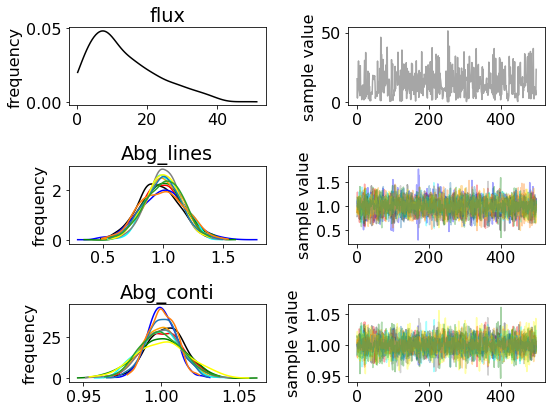

In [450]:
fit_tmp.plot(['flux','Abg_lines','Abg_conti'])
plt.tight_layout()
plt.savefig('posteriors_'+names[ndx]+'.pdf')

<h3>Print out the info we want (upper bound):</h3>

In [451]:
print('Upper bound (99.85th percentile) on the 22Na (1275 keV) flux of '+data_frame['Name'][good_novae[ndx]]+': %.1fe-5' % (np.percentile(fit_tmp['flux'],99.85)))

Upper bound (99.85th percentile) on the 22Na (1275 keV) flux of V5857 Sgr: 47.8e-5


<h3>Checking our expectation from above:</h3>

In [452]:
# maximum SNR for flux of 1e-5:
SNR_max = snr_nova_decay[-1]

# 3sigma bound wrt to this value:
print('Expected 3sigma limit: %.1fe-5' % (3/SNR_max))

Expected 3sigma limit: 53.7e-5


<h3>This value should be in the ballpart of the one above (factor of 2), then we are good to go.</h3>

<h3>Save fit info to file:</h3>

In [453]:
np.savez_compressed('save_StanFit_Nova'+data_frame['Name'][good_novae[ndx]]+'.npz',
                    fit_tmp_flux=fit_tmp['flux'],
                    fit_tmp_Abg_conti=fit_tmp['Abg_conti'],
                    fit_tmp_Abg_lines=fit_tmp['Abg_lines'])

<h3>Done, next source.</h3>

<h1>Now with fit the mass instead of the flux (basically the same), just that we have to also consider the distance to the sources:</h1>

<h3>1. Case: Distance to object is not known:</h3>

In [454]:
try:
    #read filename.pkl (if already compiled)
    model = pickle.load(open('spimodfit_nova_massfit_unknowndist_bg_conti_sep_nozeros.pkl', 'rb'))

except:
    print('Stan model not yet compiled, doing that now')
    ## compile model (if not yet compiled):
    model = pystan.StanModel('spimodfit_nova_massfit_unknowndist_bg_conti_sep_nozeros.stan')

    ## save it to the file 'filename.pkl' for later use
    with open('spimodfit_nova_massfit_unknowndist_bg_conti_sep_nozeros.pkl', 'wb') as f:
        pickle.dump(model, f)

Stan model not yet compiled, doing that now


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_53368505e781274e27c5676f7ba69ce9 NOW.


<h3>First, we 'simulate' some data to see what we would get, if we had measurable signals:</h3>

In [455]:
y_test = np.random.poisson(data[fidx:,:].ravel() + nova_model_decay[fidx:,:].ravel()*100)

<h3>And then set up our fit as before, with a few extensions:</h3>

In [456]:
# background cuts 
bg_cuts, idx_arr, Ncuts = make_bg_cuts([1]+list(cuts_decay),Np_decay)

# good indices
idx = np.where(~((data[fidx:,:].ravel() == 0) &
                 (bgl_model[fidx:,:].ravel() == 0) &
                 (bgc_model[fidx:,:].ravel() == 0)))[0] + 1

# number of good (non-zero) indices
Ngood = len(idx)

# instead of fitting flux we fit (the logarithm of) the ejected mass directly
mu_lgM = np.array([-7.])      # prior centroids for sky, we use 0 because we expect to see nothing
sigma_lgM = np.array([10.])   # width very broad (noninformative now) because we let the data talk
# because if we fit the logarithm, we have to consider a lower bound because otherwise,
# only useless samples (much to low) are considered
lgM_min = -8.

# same as before
mu_Abg_lines = 1.                      # background as before
sigma_Abg_lines = 0.2                  # same
mu_Abg_conti = 1.                      # same
sigma_Abg_conti = 0.1                  # same


# dictionary for data set and prior
data2D = dict(N = Nrsp,
              Np = Np_decay,
              Nsky = 1,
              Ncuts = Ncuts,
              Ngood = Ngood,
              good_indices = idx,
              bg_cuts = bg_cuts,
              bg_idx_arr = idx_arr,
              y = y_test.astype(int),
              bg_model_lines = np.abs(bgl_model[fidx:,:]),
              bg_model_conti = np.abs(bgc_model[fidx:,:]),
              conv_sky = nova_model_decay[fidx:,:].reshape(1,Np_decay,Nrsp), 
              mu_lgM = mu_lgM,          # new
              sigma_lgM = sigma_lgM,    # new
              lgM_min = lgM_min,        # new
              mu_Abg_lines = mu_Abg_lines,
              sigma_Abg_lines = sigma_Abg_lines,
              mu_Abg_conti = mu_Abg_conti,
              sigma_Abg_conti = sigma_Abg_conti)

# init for specific cuts
init = {}
init['lgM'] = np.array([-7.0]) # new
init['Abg_lines'] = np.repeat(1.0,Ncuts)
init['Abg_conti'] = np.repeat(1.0,Ncuts)

# optimize for test run
start = time.time()
op_tmp = model.optimizing(data=data2D,verbose=True,init=init,as_vector=False,tol_rel_grad=1e4)
print(time.time()-start)

0.5287590026855469


In [457]:
op_tmp

OrderedDict([('par',
              OrderedDict([('lgM', array(-4.7540207)),
                           ('dist', array(7.83797484)),
                           ('Abg_lines',
                            array([1.04902018, 0.83049754, 1.01372684, 0.91450964, 1.10522477,
                                   0.95408122, 0.93066336, 1.112212  , 1.06699821, 1.0334385 ,
                                   1.00661663])),
                           ('Abg_conti',
                            array([0.99740454, 1.01720323, 0.99966186, 1.01298375, 0.9895194 ,
                                   1.00913703, 1.00948571, 0.99049235, 0.99653936, 0.99994442,
                                   0.9969339 ])),
                           ('model_values',
                            array([330.38991612,   0.        ,   0.        , ..., 296.95037765,
                                     0.        , 274.23797217])),
                           ('model_values_g',
                            array([330.38991612, 273.7

<h3>Should work and 'flux' should be around 100, i.e. the value that we put in there.<br>
    Then, we fit. This <em>might<em> take longer than before (also note that we draw more samples here for this test).</h3>

In [458]:
# sample full posterior
start = time.time()
fit_tmp = model.sampling(data=data2D,
                         chains=1,
                         iter=2000,
                         n_jobs=-1,
                         verbose=True,
                         pars=['lgM','dist','flux','Abg_lines','Abg_conti'])
print(time.time()-start)

277.70862221717834


In [459]:
print(fit_tmp.stansummary(['lgM','dist','flux'],
                          probs=(0.0, 0.50-0.683/2, 0.5, 0.5+0.683/2, 0.9985)))

Inference for Stan model: anon_model_53368505e781274e27c5676f7ba69ce9.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

          mean se_mean     sd     0% 15.85%    50% 84.15% 99.85%  n_eff   Rhat
lgM[1]   -4.62    0.02   0.44  -6.42  -5.04  -4.58  -4.21  -3.59    472    1.0
dist[1]  10.33    0.16   4.83   1.12   5.74   9.64  14.82  30.66    917    1.0
flux[1]  108.8    0.46   13.9  59.97  95.33 108.41 122.75 148.97    907    1.0

Samples were drawn using NUTS at Wed Aug 12 18:40:11 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


<h3>We get out what we put in, since $F = 109 \pm 14$, and should be $100$ - good.<br>
    Now, what about the distance and the mass? Let's have a look at the sampled distributions:</h3>
    

(0, 32.92641561020189)

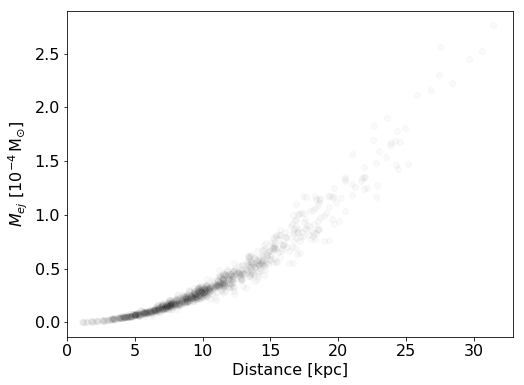

In [460]:
plt.plot(fit_tmp['dist'],10**fit_tmp['lgM']*1e4,'o',alpha=0.025)
plt.xlabel('Distance [kpc]')
plt.ylabel(r'$M_{ej}$ [$10^{-4}\,\mathrm{M_{\odot}}]$')
plt.xlim(0,)

<h3>What does this plot mean?<br>
    We are, in fact, still fitting the flux $F$, but now split it in two parameters. One we want to actually know, the mass $M_{ej}$, and one we wouldn't care about if we knew it (though would be better if we did, of course), the distance $d$.<br>
    We see in the plot above that the density of sampled points is highest around 5-10 kpc: This makes sense because this is exactly the range we put in our distance prior: $d \sim \Gamma(4.25,2.45)$. Since we don't know what $d$ actually is for this object, we sample it according to this distribution to convert $F$ to $M_{ej}$, by knowing that $F \propto M_{ej}\,d^{-2}$.<br>
    This is what is shown in the plot as a result of the fit!<br>
    Albeit the well-defined flux measurement now, we would still only get vage mass constraints. Single objects for which the distances are not (or hardly) known do not provide useful limits for themselves. However, they are still useful when considered as a population: some objects (might) have good flux constraints (but bad distance), some might have good distance constraints (but bad flux), so that comingled, they provide (hopefully) somethiing useful when combined together in one inferrence (fit).<br><br>
    Now, the other parameter combinations (of ~interest):</h3>

Text(0.5, 0, '$F$ [$10^{-5}\\,\\mathrm{ph\\,cm^{-2}\\,s^{-1}}$]')

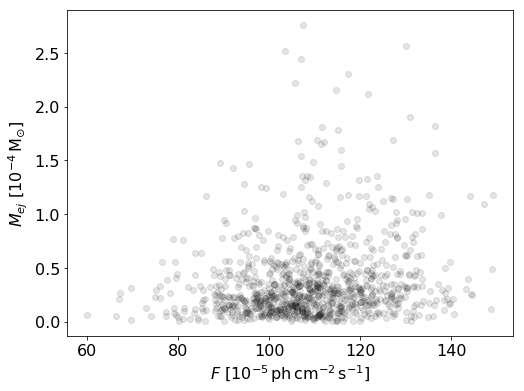

In [461]:
plt.plot(fit_tmp['flux'],10**fit_tmp['lgM']*1e4,'o',alpha=0.1)
plt.ylabel(r'$M_{ej}$ [$10^{-4}\,\mathrm{M_{\odot}}]$')
plt.xlabel(r'$F$ [$10^{-5}\,\mathrm{ph\,cm^{-2}\,s^{-1}}$]')

<h3>Similar story (of course) for $F$ and $M$: We can fit $F$ very well, but have no idea what $M$ then actually is, because we don't know the distance $d$. Most of the points are (again) sampled in this lower range because this is the range of most probable distance.</h3>

(0, 32.92641561020189)

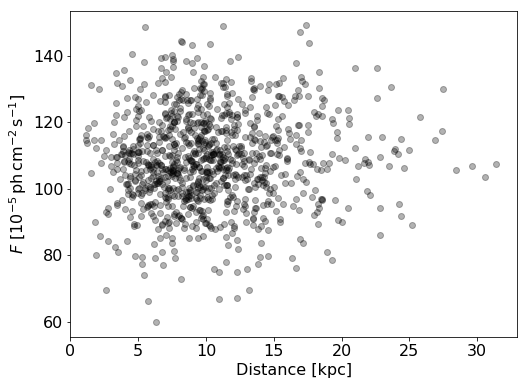

In [462]:
plt.plot(fit_tmp['dist'],fit_tmp['flux'],'o',alpha=0.3)
plt.ylabel(r'$F$ [$10^{-5}\,\mathrm{ph\,cm^{-2}\,s^{-1}}$]')
plt.xlabel('Distance [kpc]')
plt.xlim(0)

<h3>Proof of statement above.</h3>

<h3>Now the marginal posterior distributions (summing over the other dimensions):</h3>

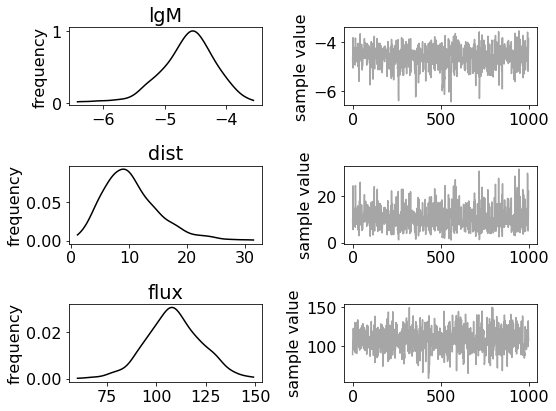

In [463]:
fit_tmp.plot(['lgM','dist','flux'])
plt.tight_layout()

<h3>Again: we actually measure flux, we assume <em>all</em> distances according to a certain distributions, which provides us with a mass.</h3>

<h3>All in once (don't worry if you can't find bayescorner)</h3>

In [464]:
import bayescorner

/usr/local/lib/python3.7/site-packages/bayescorner/compute_sigma_level.py:21: RuntimeWarning: divide by zero encountered in log
  logL = np.log(L)


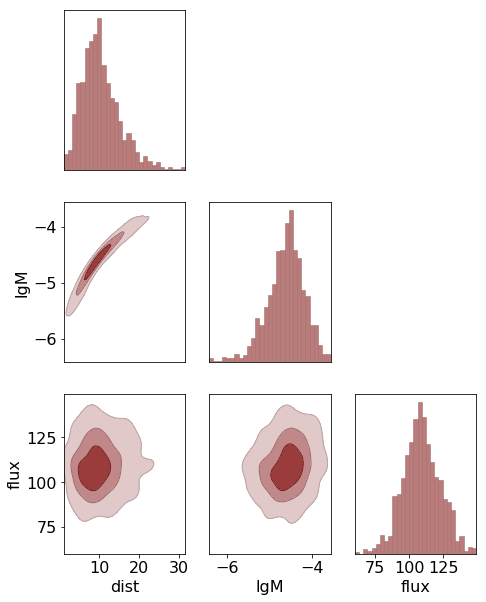

In [465]:
bayescorner.bayescorner(np.hstack([fit_tmp['lgM'],fit_tmp['flux'],fit_tmp['dist']]).T,
                        np.array(['lgM','flux','dist']));

<h3>Now with the real data of our example:</h3>

In [466]:
# background cuts 
bg_cuts, idx_arr, Ncuts = make_bg_cuts([1]+list(cuts_decay),Np_decay)

# good indices
idx = np.where(~((data[fidx:,:].ravel() == 0) &
                 (bgl_model[fidx:,:].ravel() == 0) &
                 (bgc_model[fidx:,:].ravel() == 0)))[0] + 1

# number of good (non-zero) indices
Ngood = len(idx)

mu_lgM = np.array([-7.])      # prior centroids for sky, we use 0 because we expect to see nothing
sigma_lgM = np.array([10.])   # width very broad (noninformative now) because we let the data talk
lgM_min = -8.
mu_Abg_lines = 1.                      # background as before
sigma_Abg_lines = 0.2                  # same
mu_Abg_conti = 1.                      # same
sigma_Abg_conti = 0.1                  # same


# dictionary for data set and prior
data2D = dict(N = Nrsp,
              Np = Np_decay,
              Nsky = 1,
              Ncuts = Ncuts,
              Ngood = Ngood,
              good_indices = idx,
              bg_cuts = bg_cuts,
              bg_idx_arr = idx_arr,
              y = data[fidx:,:].ravel().astype(int),
              bg_model_lines = np.abs(bgl_model[fidx:,:]),
              bg_model_conti = np.abs(bgc_model[fidx:,:]),
              conv_sky = nova_model_decay[fidx:,:].reshape(1,Np_decay,Nrsp), 
              mu_lgM = mu_lgM,
              sigma_lgM = sigma_lgM,
              lgM_min = lgM_min,
              mu_Abg_lines = mu_Abg_lines,
              sigma_Abg_lines = sigma_Abg_lines,
              mu_Abg_conti = mu_Abg_conti,
              sigma_Abg_conti = sigma_Abg_conti)

# init for specific cuts
init = {}
init['lgM'] = np.array([-7.0])
init['Abg_lines'] = np.repeat(1.0,Ncuts)
init['Abg_conti'] = np.repeat(1.0,Ncuts)

# optimize for test run
start = time.time()
op_tmp = model.optimizing(data=data2D,verbose=True,init=init,as_vector=False,tol_rel_grad=1e4)
print(time.time()-start)

0.19182395935058594


In [467]:
op_tmp

OrderedDict([('par',
              OrderedDict([('lgM', array(-6.95553655)),
                           ('dist', array(7.86912871)),
                           ('Abg_lines',
                            array([0.96388275, 0.9986168 , 1.00232597, 1.00011858, 0.99560593,
                                   0.99297297, 0.99825679, 0.99874438, 1.00001628, 0.99942042,
                                   0.99746982])),
                           ('Abg_conti',
                            array([1.00401874, 1.00049336, 1.00074246, 1.00040992, 1.00105817,
                                   1.00118265, 1.00066578, 1.00063545, 1.00048094, 1.00048165,
                                   1.00069654])),
                           ('model_values',
                            array([330.5893237 ,   0.        ,   0.        , ..., 297.79671246,
                                     0.        , 275.0174029 ])),
                           ('model_values_g',
                            array([330.5893237 , 273.

In [468]:
# sample full posterior
start = time.time()
fit_tmp = model.sampling(data=data2D,
                         chains=1,
                         iter=2000,
                         n_jobs=-1,
                         verbose=True,
                         pars=['lgM','dist','flux','Abg_lines','Abg_conti'])
print(time.time()-start)

289.6998372077942


In [469]:
print(fit_tmp.stansummary(['lgM','dist','flux'],
                          probs=(0.0, 0.50-0.683/2, 0.5, 0.5+0.683/2, 0.9985)))

Inference for Stan model: anon_model_53368505e781274e27c5676f7ba69ce9.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

          mean se_mean     sd     0% 15.85%    50% 84.15% 99.85%  n_eff   Rhat
lgM[1]   -6.57    0.05   0.86  -7.99  -7.58  -6.56   -5.6  -4.49    254    1.0
dist[1]  11.01    0.14   5.03    1.7   6.05  10.35  15.85  35.55   1354    1.0
flux[1]   4.13    0.24   6.13 6.6e-3   0.11   1.26   8.88  38.96    629    1.0

Samples were drawn using NUTS at Wed Aug 12 18:51:13 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


<h3>Compared to our fit for flux only (see last week or first fit in this notebook), we now get a slightly lower flux estimate (though should still be the same within a few ten %).<br>
    This is explained by the fact that<br>
    $F \propto M\,d^{-2}$,<br>
    and to get a similarly high value of $F$ as before, we need (at the same time) a high $M$-value and a low $d$-value. High $M$-value are easily allowed in the fit, our prior is very uninformative in this sense. However, low $d$-values (e.g., $<1\,\mathrm{kpc}$ if you remember) are very unlikely. This means, that even if we don't know what the distance is, we actually inform our model (and consequently the flux) by knowing that it is now right in front of us!<br>
    Consider the following plot of sampled points:</h3>

In [470]:
d_arr = np.linspace(0,30,100)

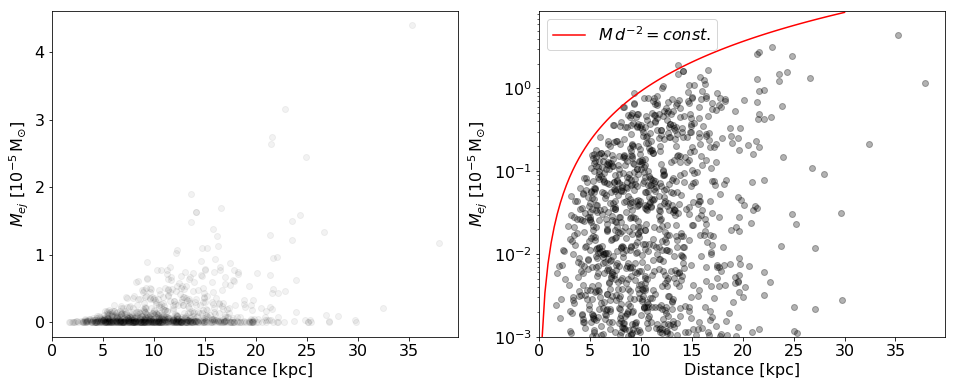

In [471]:
plt.figure(figsize=(16,6))

plt.subplot(121)
plt.plot(fit_tmp['dist'],10**fit_tmp['lgM']*1e5,'o',alpha=0.05)
#plt.plot(d_arr,(d_arr/(4.25*2.45))**2,label=r'$M\,d^{-2} = const.$')
plt.xlabel('Distance [kpc]')
plt.ylabel(r'$M_{ej}$ [$10^{-5}\,\mathrm{M_{\odot}}]$')
plt.xlim(0,)

plt.subplot(122)
plt.plot(fit_tmp['dist'],10**fit_tmp['lgM']*1e5,'o',alpha=0.3)
plt.plot(d_arr,(d_arr/(4.25*2.45))**2,label=r'$M\,d^{-2} = const.$')
plt.legend()
plt.xlabel('Distance [kpc]')
plt.ylabel(r'$M_{ej}$ [$10^{-5}\,\mathrm{M_{\odot}}]$')
plt.xlim(0,)
plt.ylim(1e-3)
plt.yscale('log')

<h3>This is the same plot as above for our simulated example, but now we don't detect the source.<br>
    In the left plot (linear scale), we see that nearly no matter what distance we seletct, we get a similar mass estimate. Only a few points seem to follow the same trend from above. However, if we look at the sampled mass in log-space, we actually see the same trend as above, but with allowed points up to certain enveloping function. As you now know, this curve is $M\,d^{-2} = const.$, defining our upper bound. You see that the points 'close' to this line are actually very sparse, which lets our flux limit <em>appear</em> smaller.</h3>

In [472]:
F_arr = np.logspace(-3,2,100)

(0.001, 55.30667339036643)

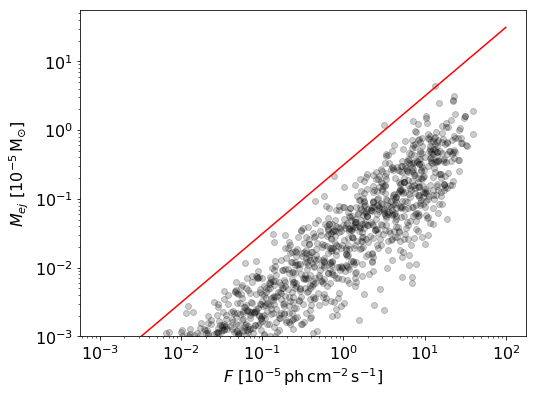

In [473]:
plt.loglog(fit_tmp['flux'],10**fit_tmp['lgM']*1e5,'o',alpha=0.2)
plt.plot(F_arr,F_arr*33.72/(4.25*2.45)**2,color='red')
plt.ylabel(r'$M_{ej}$ [$10^{-5}\,\mathrm{M_{\odot}}]$')
plt.xlabel(r'$F$ [$10^{-5}\,\mathrm{ph\,cm^{-2}\,s^{-1}}$]')
plt.ylim(1e-3)

/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0, 0.5, '$F$ [$10^{-5}\\,\\mathrm{ph\\,cm^{-2}\\,s^{-1}}$]')

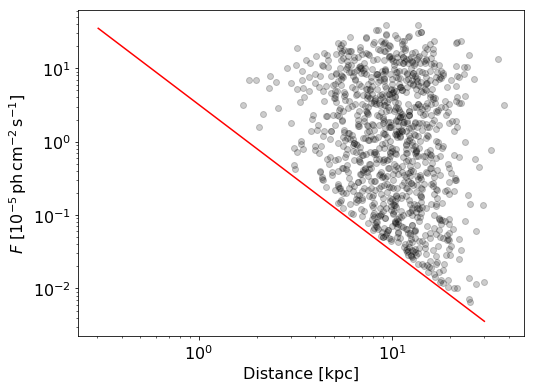

In [474]:
plt.loglog(fit_tmp['dist'],fit_tmp['flux'],'o',alpha=0.2)
plt.plot(d_arr,1/(d_arr/(4.25*2.45))**2/33.72,color='red')
plt.xlabel('Distance [kpc]')
plt.ylabel(r'$F$ [$10^{-5}\,\mathrm{ph\,cm^{-2}\,s^{-1}}$]')

<h3>The posteriors might look a bit misleading, since $lgM$ is in fact almost uniform with a cutoff defining the upper bound:</h3>

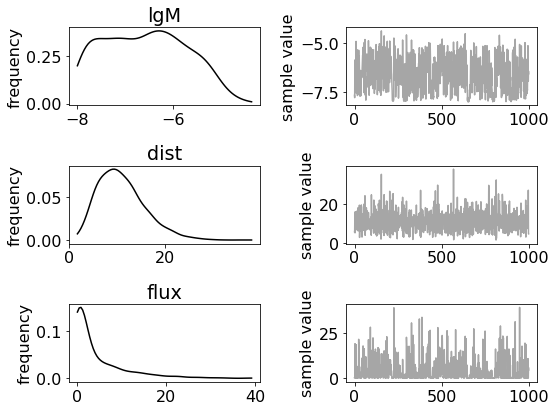

In [475]:
fit_tmp.plot(['lgM','dist','flux'],)
plt.tight_layout()
#plt.savefig('posteriors_'+names[ndx]+'.pdf')

In [476]:
"""bayescorner.bayescorner(np.hstack([fit_tmp['lgM'],fit_tmp['flux'],fit_tmp['dist']]).T,
                        np.array(['lgM','flux','dist']),);""";

<h3>This becomes clearer when we look at the prior and posterior in more detail and not smoothed:</h3>

In [477]:
from scipy import stats
from scipy.ndimage import gaussian_filter1d as smooth

In [478]:
lgM_arr = np.linspace(-8.5,10,5000)
lower, upper = -8, np.inf
mu, sigma = -7, 10
lgM_prior = stats.truncnorm(
            (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)

Text(0.5, 0, '$\\lg M$')

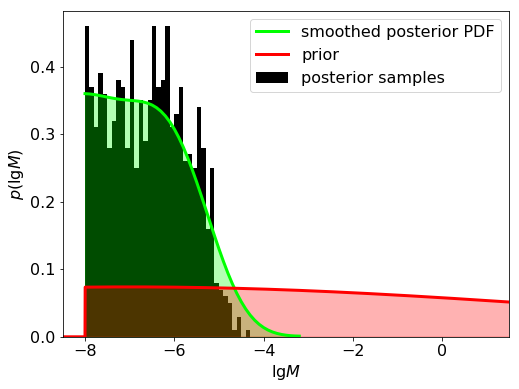

In [480]:
tmp = np.histogram(fit_tmp['lgM'],bins=np.arange(-8,-3,0.1),density=True)

plt.hist(fit_tmp['lgM'],bins=np.arange(-8,-3,0.1),density=True,label='posterior samples',zorder=-100);
plt.plot(tmp[1][0:-1],smooth(tmp[0],6),color='lime',label='smoothed posterior PDF',linewidth=3)
plt.fill_between(tmp[1][0:-1],smooth(tmp[0],6),np.zeros(len(tmp[1][0:-1])),color='lime',alpha=0.3)

plt.plot(lgM_arr,lgM_prior.pdf(lgM_arr),color='red',linewidth=3,label='prior')
plt.fill_between(lgM_arr,lgM_prior.pdf(lgM_arr),np.zeros(len(lgM_arr)),color='red',alpha=0.3)

plt.legend()
plt.xlim(-8.5,1.5)
plt.ylabel(r'$p(\lg M)$')
plt.xlabel(r'$\lg M$')

<h3>Clearly, because of the lower threshold, some more points accumulate there, but which we are mainly not interested in for the case of an uninformative prior (red, very extended, provides no information for the fit, except $\lg M > -8$). Still our data tells us, we must have a mass $M < 10^{-4.48}\,\mathrm{M_{\odot}} \approx 3 \times 10^{-5}\,\mathrm{M_{\odot}}$ (99.85th percentile).<br>
    This is in itself, not a very good estimate, but we only consider one object! For many objects and then adding the diffuse part (biggest impact), we will get (I hope) a much better value so that we could add something to the literature.<br><br>
    I still have no idea how good this wll be in the end, but also a `this doesn't help much' is valuable information in science, so that nobody else will try it, invest a lot of time, and fail the same way.</h3>

<h3>2. Case: Distance to object <em>is</em> known:</h3>

In [498]:
try:
    #read filename.pkl (if already compiled)
    model = pickle.load(open('spimodfit_nova_massfit_knowndist_bg_conti_sep_nozeros.pkl', 'rb'))

except:
    print('Stan model not yet compiled, doing that now')
    ## compile model (if not yet compiled):
    model = pystan.StanModel('spimodfit_nova_massfit_knowndist_bg_conti_sep_nozeros.stan')

    ## save it to the file 'filename.pkl' for later use
    with open('spimodfit_nova_massfit_knowndist_bg_conti_sep_nozeros.pkl', 'wb') as f:
        pickle.dump(model, f)

<h3>Same game as before, now we assuming also to know a distance:</h3>

In [482]:
y_test2 = np.random.poisson(data[fidx:,:].ravel() + nova_model_decay[fidx:,:].ravel()*100)
d_test2 = 4.
d_test2_err = 1.5

<h3>Setting up fit:</h3>

In [483]:
# background cuts 
bg_cuts, idx_arr, Ncuts = make_bg_cuts([1]+list(cuts_decay),Np_decay)

# good indices
idx = np.where(~((data[fidx:,:].ravel() == 0) &
                 (bgl_model[fidx:,:].ravel() == 0) &
                 (bgc_model[fidx:,:].ravel() == 0)))[0] + 1

# number of good (non-zero) indices
Ngood = len(idx)

# instead of fitting flux we fit (the logarithm of) the ejected mass directly
mu_lgM = np.array([-7.])      # prior centroids for sky, we use 0 because we expect to see nothing
sigma_lgM = np.array([10.])   # width very broad (noninformative now) because we let the data talk
# because if we fit the logarithm, we have to consider a lower bound because otherwise,
# only useless samples (much to low) are considered
lgM_min = -8.

# same as before
mu_Abg_lines = 1.                      # background as before
sigma_Abg_lines = 0.2                  # same
mu_Abg_conti = 1.                      # same
sigma_Abg_conti = 0.1                  # same


# dictionary for data set and prior
data2D = dict(N = Nrsp,
              Np = Np_decay,
              Nsky = 1,
              Ncuts = Ncuts,
              Ngood = Ngood,
              good_indices = idx,
              bg_cuts = bg_cuts,
              bg_idx_arr = idx_arr,
              y = y_test2.astype(int),
              bg_model_lines = np.abs(bgl_model[fidx:,:]),
              bg_model_conti = np.abs(bgc_model[fidx:,:]),
              conv_sky = nova_model_decay[fidx:,:].reshape(1,Np_decay,Nrsp), 
              mu_lgM = mu_lgM,          
              sigma_lgM = sigma_lgM,    
              lgM_min = lgM_min,        
              distance_mu = np.array([d_test2]),
              distance_sigma = np.array([d_test2_err]),
              mu_Abg_lines = mu_Abg_lines,
              sigma_Abg_lines = sigma_Abg_lines,
              mu_Abg_conti = mu_Abg_conti,
              sigma_Abg_conti = sigma_Abg_conti)

# init for specific cuts
init = {}
init['lgM'] = np.array([-7.0]) # new
init['Abg_lines'] = np.repeat(1.0,Ncuts)
init['Abg_conti'] = np.repeat(1.0,Ncuts)

# optimize for test run
start = time.time()
op_tmp = model.optimizing(data=data2D,verbose=True,init=init,as_vector=False,tol_rel_grad=1e4)
print(time.time()-start)

0.6035709381103516


In [484]:
op_tmp

OrderedDict([('par',
              OrderedDict([('lgM', array(-5.33567332)),
                           ('dist', array(3.95432693)),
                           ('Abg_lines',
                            array([0.96060278, 1.00946938, 0.86211995, 0.99588929, 0.96677856,
                                   1.0188934 , 0.90454047, 0.91255118, 0.9645982 , 1.03495369,
                                   1.01729057])),
                           ('Abg_conti',
                            array([1.00338775, 0.99724508, 1.00520021, 1.00151176, 1.00464355,
                                   0.9966603 , 1.00608846, 1.00765757, 1.00249587, 0.99819008,
                                   0.9972087 ])),
                           ('model_values',
                            array([330.53167532,   0.        ,   0.        , ..., 297.25260915,
                                     0.        , 274.51883135])),
                           ('model_values_g',
                            array([330.53167532, 273.

In [485]:
# sample full posterior
start = time.time()
fit_tmp = model.sampling(data=data2D,
                         chains=1,
                         iter=2000,
                         n_jobs=-1,
                         verbose=True,
                         pars=['lgM','dist','flux','Abg_lines','Abg_conti'])
print(time.time()-start)

415.65464878082275


In [486]:
print(fit_tmp.stansummary(['lgM','dist','flux'],
                          probs=(0.0, 0.50-0.683/2, 0.5, 0.5+0.683/2, 0.9985)))

Inference for Stan model: anon_model_c420c4ae3663ec9548262d78e945e0fe.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

          mean se_mean     sd     0% 15.85%    50% 84.15% 99.85%  n_eff   Rhat
lgM[1]   -5.42    0.02   0.41  -7.33  -5.78  -5.34  -5.05  -4.67    403    1.0
dist[1]   3.99    0.06   1.51    0.5   2.42   3.97   5.55   8.38    719    1.0
flux[1] 111.42     0.5  14.74  66.24  97.55 111.11 125.69 154.87    874    1.0

Samples were drawn using NUTS at Wed Aug 12 19:39:23 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


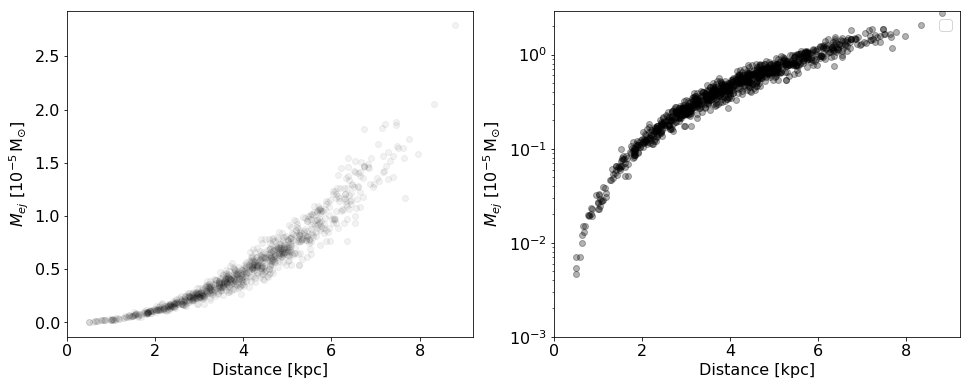

In [487]:
plt.figure(figsize=(16,6))

plt.subplot(121)
plt.plot(fit_tmp['dist'],10**fit_tmp['lgM']*1e5,'o',alpha=0.05)
#plt.plot(d_arr,(d_arr/(4.25*2.45))**2,label=r'$M\,d^{-2} = const.$')
plt.xlabel('Distance [kpc]')
plt.ylabel(r'$M_{ej}$ [$10^{-5}\,\mathrm{M_{\odot}}]$')
plt.xlim(0,)

plt.subplot(122)
plt.plot(fit_tmp['dist'],10**fit_tmp['lgM']*1e5,'o',alpha=0.3)
plt.legend()
plt.xlabel('Distance [kpc]')
plt.ylabel(r'$M_{ej}$ [$10^{-5}\,\mathrm{M_{\odot}}]$')
plt.xlim(0,)
plt.ylim(1e-3)
plt.yscale('log')

In [488]:
"""plt.loglog(fit_tmp['flux'],10**fit_tmp['lgM']*1e5,'o',alpha=0.2)
plt.ylabel(r'$M_{ej}$ [$10^{-5}\,\mathrm{M_{\odot}}]$')
plt.xlabel(r'$F$ [$10^{-5}\,\mathrm{ph\,cm^{-2}\,s^{-1}}$]')
plt.ylim(1e-3)""";

In [489]:
"""plt.loglog(fit_tmp['dist'],fit_tmp['flux'],'o',alpha=0.2)
plt.xlabel('Distance [kpc]')
plt.ylabel(r'$F$ [$10^{-5}\,\mathrm{ph\,cm^{-2}\,s^{-1}}$]')""";

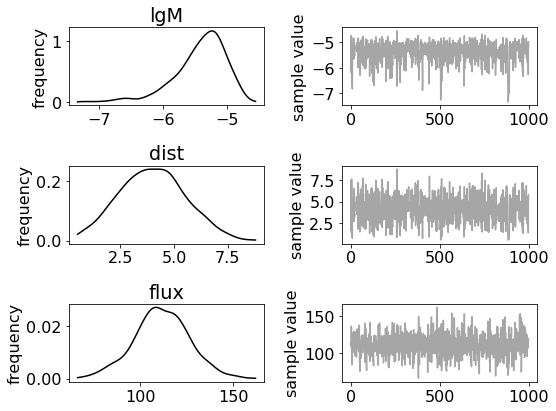

In [490]:
fit_tmp.plot(['lgM','dist','flux'],)
plt.tight_layout()
#plt.savefig('posteriors_'+names[ndx]+'.pdf')

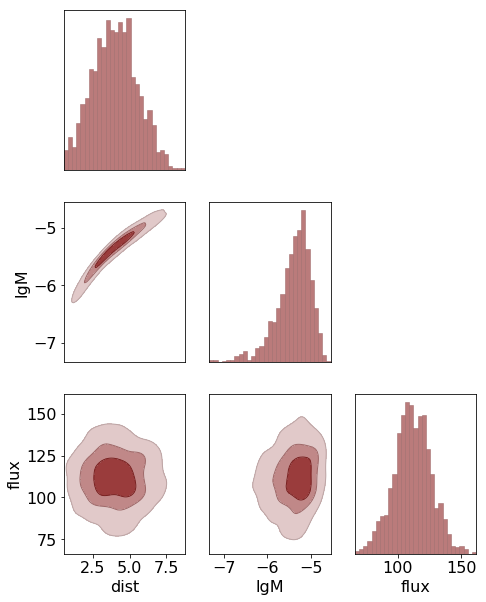

In [491]:
bayescorner.bayescorner(np.hstack([fit_tmp['lgM'],fit_tmp['flux'],fit_tmp['dist']]).T,
                        np.array(['lgM','flux','dist']),);

<h3>How do we distinguish between "known" and "unknown" distance?<br>
    In our catalogue file, we have quite often a distance $d \pm \sigma_d = 8.179 \pm 16.358$. As you might remember, this is not a real estimate of the distance, but actually means "somewhere inside the Milky Way" - in particular a quite good guess (because it's not outside).<br>
    That means, every time we have this value in the catalogue, it actually means the distance is unknown. Every other value, for example
    <p style="font-family:Courier"> 51 V1324 Sco 357.426 -2.872 4.3   0.9 5.80E-05 Sohan</p><br>
    has a distance of $4.3 \pm 0.9$, so we would use case 2.<br>
    This means, we have to check the distance estimate before we do the fit to load the correct model!</h3>

In [492]:
# background cuts 
bg_cuts, idx_arr, Ncuts = make_bg_cuts([1]+list(cuts_decay),Np_decay)

# good indices
idx = np.where(~((data[fidx:,:].ravel() == 0) &
                 (bgl_model[fidx:,:].ravel() == 0) &
                 (bgc_model[fidx:,:].ravel() == 0)))[0] + 1

# number of good (non-zero) indices
Ngood = len(idx)

# instead of fitting flux we fit (the logarithm of) the ejected mass directly
mu_lgM = np.array([-7.])      # prior centroids for sky, we use 0 because we expect to see nothing
sigma_lgM = np.array([10.])   # width very broad (noninformative now) because we let the data talk
# because if we fit the logarithm, we have to consider a lower bound because otherwise,
# only useless samples (much to low) are considered
lgM_min = -8.

# same as before
mu_Abg_lines = 1.                      # background as before
sigma_Abg_lines = 0.2                  # same
mu_Abg_conti = 1.                      # same
sigma_Abg_conti = 0.1                  # same


# dictionary for data set and prior
data2D = dict(N = Nrsp,
              Np = Np_decay,
              Nsky = 1,
              Ncuts = Ncuts,
              Ngood = Ngood,
              good_indices = idx,
              bg_cuts = bg_cuts,
              bg_idx_arr = idx_arr,
              y = data[fidx:,:].ravel().astype(int),
              bg_model_lines = np.abs(bgl_model[fidx:,:]),
              bg_model_conti = np.abs(bgc_model[fidx:,:]),
              conv_sky = nova_model_decay[fidx:,:].reshape(1,Np_decay,Nrsp), 
              mu_lgM = mu_lgM,          
              sigma_lgM = sigma_lgM,    
              lgM_min = lgM_min,        
              distance_mu = np.array([d_test2]),
              distance_sigma = np.array([d_test2_err]),
              mu_Abg_lines = mu_Abg_lines,
              sigma_Abg_lines = sigma_Abg_lines,
              mu_Abg_conti = mu_Abg_conti,
              sigma_Abg_conti = sigma_Abg_conti)

# init for specific cuts
init = {}
init['lgM'] = np.array([-7.0]) # new
init['Abg_lines'] = np.repeat(1.0,Ncuts)
init['Abg_conti'] = np.repeat(1.0,Ncuts)

# optimize for test run
start = time.time()
op_tmp = model.optimizing(data=data2D,verbose=True,init=init,as_vector=False,tol_rel_grad=1e4)
print(time.time()-start)

0.17579865455627441


In [493]:
# sample full posterior
start = time.time()
fit_tmp = model.sampling(data=data2D,
                         chains=1,
                         iter=2000,
                         n_jobs=-1,
                         verbose=True,
                         pars=['lgM','dist','flux','Abg_lines','Abg_conti'])
print(time.time()-start)

260.204461812973


In [494]:
print(fit_tmp.stansummary(['lgM','dist','flux'],
                          probs=(0.0, 0.50-0.683/2, 0.5, 0.5+0.683/2, 0.9985)))

Inference for Stan model: anon_model_c420c4ae3663ec9548262d78e945e0fe.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

          mean se_mean     sd     0% 15.85%    50% 84.15% 99.85%  n_eff   Rhat
lgM[1]   -6.97    0.03   0.62   -8.0  -7.67  -6.98  -6.25  -5.51    470    1.0
dist[1]   4.31    0.04   1.45    0.5   2.75   4.28   5.76   8.56   1700    1.0
flux[1]   5.76    0.26   7.16   0.09   0.52   2.76   12.1  40.14    763    1.0

Samples were drawn using NUTS at Wed Aug 12 19:50:25 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


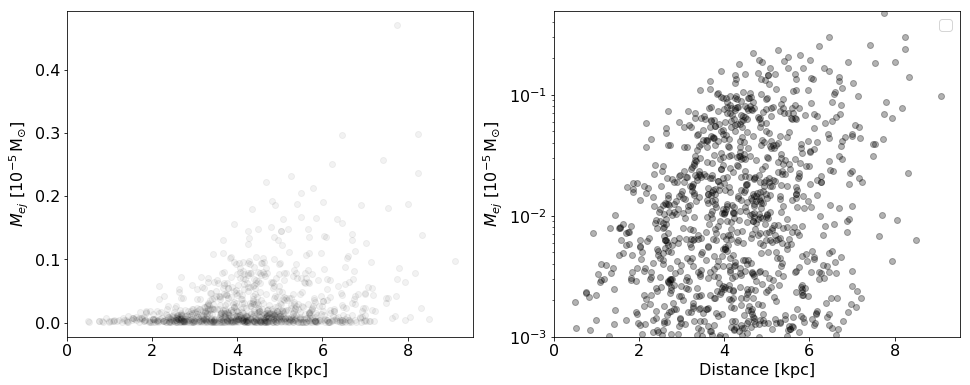

In [495]:
plt.figure(figsize=(16,6))

plt.subplot(121)
plt.plot(fit_tmp['dist'],10**fit_tmp['lgM']*1e5,'o',alpha=0.05)
#plt.plot(d_arr,(d_arr/(4.25*2.45))**2,label=r'$M\,d^{-2} = const.$')
plt.xlabel('Distance [kpc]')
plt.ylabel(r'$M_{ej}$ [$10^{-5}\,\mathrm{M_{\odot}}]$')
plt.xlim(0,)

plt.subplot(122)
plt.plot(fit_tmp['dist'],10**fit_tmp['lgM']*1e5,'o',alpha=0.3)
plt.legend()
plt.xlabel('Distance [kpc]')
plt.ylabel(r'$M_{ej}$ [$10^{-5}\,\mathrm{M_{\odot}}]$')
plt.xlim(0,)
plt.ylim(1e-3)
plt.yscale('log')

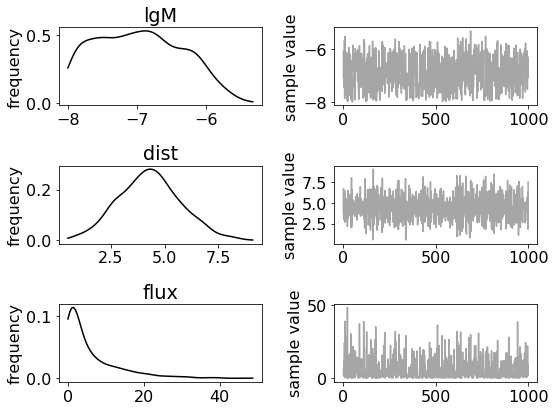

In [496]:
fit_tmp.plot(['lgM','dist','flux'],)
plt.tight_layout()
#plt.savefig('posteriors_'+names[ndx]+'.pdf')

Text(0.5, 0, '$\\lg M$')

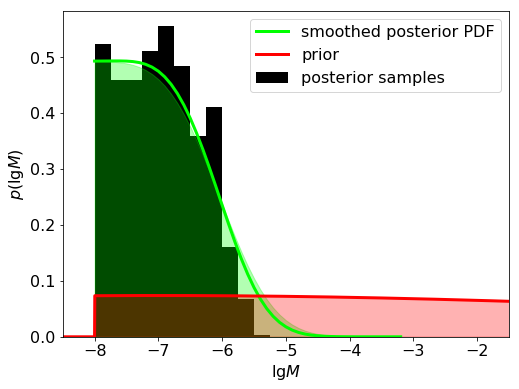

In [497]:
tmp = np.histogram(fit_tmp['lgM'],bins=np.arange(-8,-3,0.1),density=True)

plt.hist(fit_tmp['lgM'],bins=np.arange(-8,-3,0.25),density=True,label='posterior samples',zorder=-100);
plt.plot(tmp[1][0:-1],smooth(tmp[0],5),color='lime',label='smoothed posterior PDF',linewidth=3)
plt.fill_between(tmp[1][0:-1],smooth(tmp[0],6),np.zeros(len(tmp[1][0:-1])),color='lime',alpha=0.3)

plt.plot(lgM_arr,lgM_prior.pdf(lgM_arr),color='red',linewidth=3,label='prior')
plt.fill_between(lgM_arr,lgM_prior.pdf(lgM_arr),np.zeros(len(lgM_arr)),color='red',alpha=0.3)

plt.legend()
plt.xlim(-8.5,-1.5)
plt.ylabel(r'$p(\lg M)$')
plt.xlabel(r'$\lg M$')

<h1>List of objects for everyone:</h1>

<h3>Akshay:</h3>

In [32]:
print('Objects: ',names[::5])
print('Indices: ',np.arange(len(names))[::5])

Objects:  ['V556 Nor' 'V435 CMa' 'V1662 Sco' 'V1660 Sco' 'V1657 Sco' 'V611 Sct'
 'V555 Nor' 'V2944 Oph' 'V2659 Cyg' 'V1533 Sco' 'V959 Mon' 'V965 Per'
 'V5586 Sgr' 'V496 Sct' 'V1721 Aql' 'V5579 Sgr' 'V598 Pup' 'V2576 Oph'
 'V5115 Sgr' 'DE Cir' 'V2540 Oph']
Indices:  [  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100]


<h3>Sohan:</h3>

In [34]:
print('Objects: ',names[1::5])
print('Indices: ',np.arange(len(names))[1::5])

Objects:  ['V3666 Oph' 'V906 Car' 'FM Cir' 'V549 Vel' 'V5856 Sgr' 'V1656 Sco'
 'V5850 Sgr' 'V1404 Cen' 'V5666 Sgr' 'V809 Cep' 'V1324 Sco' 'V1313 Sco'
 'V1310 Sco' 'V5581 Sgr' 'V679 Car' 'NR TrA' 'V1280 Sco' 'V5117 Sgr'
 'V5116 Sgr' 'DZ Cru' 'V4743 Sgr']
Indices:  [  1   6  11  16  21  26  31  36  41  46  51  56  61  66  71  76  81  86
  91  96 101]


<h3>Ethan:</h3>

In [35]:
print('Objects: ',names[2::5])
print('Indices: ',np.arange(len(names))[2::5])

Objects:  ['V613 Sct' 'V3665 Oph' 'V1661 Sco' 'V612 Sct' 'V5855 Sgr' 'V5853 Sgr'
 'V2949 Oph' 'V1658 Sco' 'V1830 Aql' 'V1724 Aql' 'V5589 Sgr' 'V5588 Sgr'
 'V5585 Sgr' 'V5582 Sgr' 'V2468 Cyg' 'V1065 Cen' 'V5558 Sgr' 'V1047 Cen'
 'V574 Pup' 'V475 Sct']
Indices:  [ 2  7 12 17 22 27 32 37 42 47 52 57 62 67 72 77 82 87 92 97]


<h3>Kalp:</h3>

In [36]:
print('Objects: ',names[3::5])
print('Indices: ',np.arange(len(names))[3::5])

Objects:  ['V408 Lup' 'V1663 Sco' 'V357 Mus' 'V1405 Cen' 'V407 Lup' 'V5854 Sgr '
 'V1831 Aql' 'V1535 Sco' 'V556 Ser' 'V5593 Sgr' 'V5591 Sgr' 'V5587 Sgr'
 'V2674 Oph' 'V5580 Sgr' 'V2491 Cyg' 'V2467 Cyg' 'V458 Vul' 'V382 Nor'
 'V1186 Sco' 'V5113 Sgr']
Indices:  [ 3  8 13 18 23 28 33 38 43 48 53 58 63 68 73 78 83 88 93 98]


<h3>Thomas:</h3>

In [37]:
print('Objects: ',names[4::5])
print('Indices: ',np.arange(len(names))[4::5])

Objects:  ['V5857 Sgr' 'V3664 Oph' 'V3663 Oph' 'V3662 Oph' 'V1659 Sco' 'V1655 Sco'
 'V5669 Sgr' 'V5668 Sgr' 'V339 Del' 'V5592 Sgr' 'V2676 Oph' 'V1723 Aql '
 'V2672 Oph' 'V1212 Cen' 'QY Mus' 'V2615 Oph' 'V459 Vul' 'V476 Sct'
 'V1187 Sco' 'V4744 Sgr']
Indices:  [ 4  9 14 19 24 29 34 39 44 49 54 59 64 69 74 79 84 89 94 99]


In [29]:
# 1)
ra_spi  = poin['RA_SPIX']
dec_spi = poin['DEC_SPIX']

# 2)
poin_coords = SkyCoord(ra=ra_spi,
                       dec=dec_spi,
                       unit='deg')
# this creates an object which holds RA and DEC values in units of degrees

lon_spi = poin_coords.galactic.l.value
lon_spi[lon_spi>180]-=360 # shifting the coordiantes to -180 to +180 deg
lat_spi = poin_coords.galactic.b.value

In [40]:
livetime = dead['livetime'].reshape(Np,Nrsp)

In [33]:
Nn = len(good_novae)
Nn
# 2)
c_arr = []
# 1)
for i in range(Nn):
    c = SkyCoord(ra=data_frame['Ra\n(deg)'][good_novae[i]],
                 dec=data_frame['Dec\n(deg)'][good_novae[i]],
                 unit=(u.degree, u.degree))
    c_arr.append([c.galactic.l.deg,
                  c.galactic.b.deg,
                  data_frame['l\n(deg)'][good_novae[i]],
                  data_frame['b\n(deg)'][good_novae[i]]])
# 2)
c_arr = np.array(c_arr)
c_arr[np.where(c_arr > 180)] -= 360

# 3)
ndx = 4

In [34]:
T0 = data_frame['IJD'][good_novae].values[ndx]
T0

6672.7229976851895

In [48]:
np.sum(poin['TELAPSE'][(poin['TSTART'] > T0) &
                       (angular_distance(lon_spi,lat_spi,c_arr[ndx,0],c_arr[ndx,1]) < 16)])

169755.87871758034

In [47]:
np.sum(np.mean(livetime[(poin['TSTART'] > T0) &
                       (angular_distance(lon_spi,lat_spi,c_arr[ndx,0],c_arr[ndx,1]) < 24),:],axis=1))

174363.13520916947

In [57]:
for i in range(len(good_novae)):
    ndx = i
    T0 = data_frame['IJD'][good_novae].values[ndx]
    #print(np.arange(len(names))[i],
    #      names[i],np.sum(np.mean(livetime[(poin['TSTART'] > T0) &
    #                   (angular_distance(lon_spi,lat_spi,c_arr[ndx,0],c_arr[ndx,1]) < 24),:],axis=1))/1e6)
    print('%.2f' % (np.sum(np.mean(livetime[(poin['TSTART'] > T0) &
                       (angular_distance(lon_spi,lat_spi,c_arr[ndx,0],c_arr[ndx,1]) < 16),:],axis=1))/1e6))

0.00
0.00
0.00
0.00
0.11
0.00
0.36
0.42
0.49
0.66
0.27
0.00
0.79
0.36
0.67
0.98
0.15
0.31
1.01
1.17
1.77
2.06
2.21
1.25
3.14
0.55
3.17
3.20
3.30
3.44
1.57
3.15
4.04
2.74
4.26
4.31
2.59
5.48
5.73
4.73
3.82
5.70
3.74
1.36
3.32
7.86
2.75
3.69
8.18
9.68
0.75
9.98
9.35
9.15
9.36
1.08
4.84
10.44
10.87
3.98
11.76
12.30
12.04
12.13
12.36
3.71
12.29
11.73
12.39
3.56
6.64
4.54
7.80
7.49
3.18
13.34
4.83
5.92
9.06
14.95
0.36
16.18
14.45
7.58
7.43
17.79
19.21
6.64
9.18
8.56
19.65
19.52
2.09
22.31
22.84
8.29
8.71
9.99
23.78
25.55
22.23
10.95
